In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg





In [102]:
# Load the dataset
data = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'], index_col='Date')

# Focus on the 'Open' prices
open_prices = data['Open']


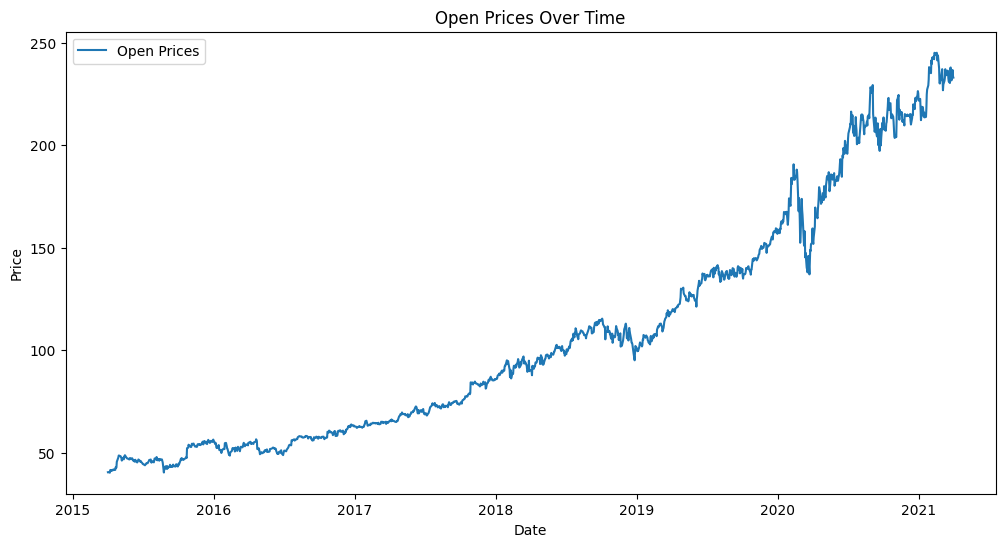

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(open_prices, label='Open Prices')
plt.title('Open Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


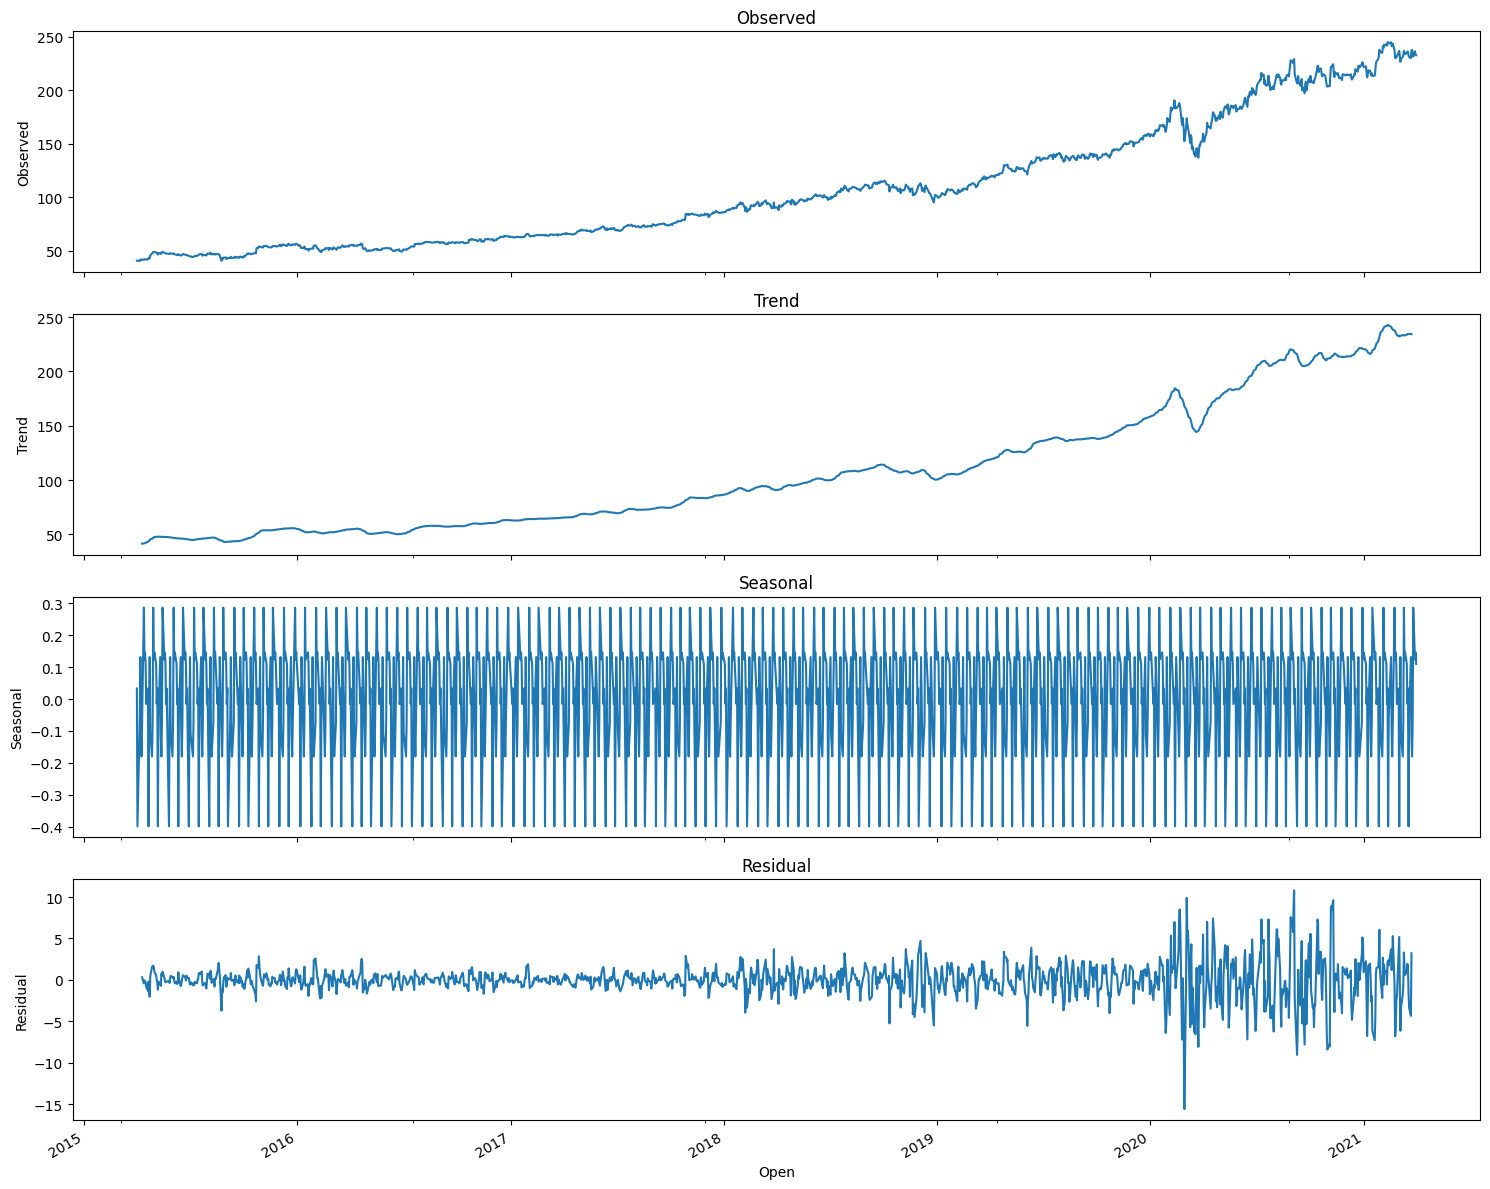

In [104]:
decomposition = seasonal_decompose(open_prices, model='multiplicative', period=365)
result = seasonal_decompose(open_prices, model='additive', period=12)
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Open')
plt.tight_layout()
plt.show()

## Autoregression

In [105]:
open_prices

Date
2015-04-01 16:00:00     40.60
2015-04-02 16:00:00     40.66
2015-04-06 16:00:00     40.34
2015-04-07 16:00:00     41.61
2015-04-08 16:00:00     41.48
                        ...  
2021-03-25 16:00:00    235.30
2021-03-26 16:00:00    231.55
2021-03-29 16:00:00    236.59
2021-03-30 16:00:00    233.53
2021-03-31 16:00:00    232.91
Name: Open, Length: 1511, dtype: float64

In [106]:
# Adding lag features to the DataFrame
for i in range(1, 135): # Creating lag features up to 5 days
	data[f'Lag_{i}'] = open_prices.shift(i)

# Drop rows with NaN values resulting from creating lag features
data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Define the input features (lag features) and target variable

y_train = train_data['Open']

y_test = test_data['Open']


C:\Users\71518\AppData\Local\Temp\ipykernel_14760\1093802665.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Lag_{i}'] = open_prices.shift(i)
C:\Users\71518\AppData\Local\Temp\ipykernel_14760\1093802665.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Lag_{i}'] = open_prices.shift(i)
C:\Users\71518\AppData\Local\Temp\ipykernel_14760\1093802665.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

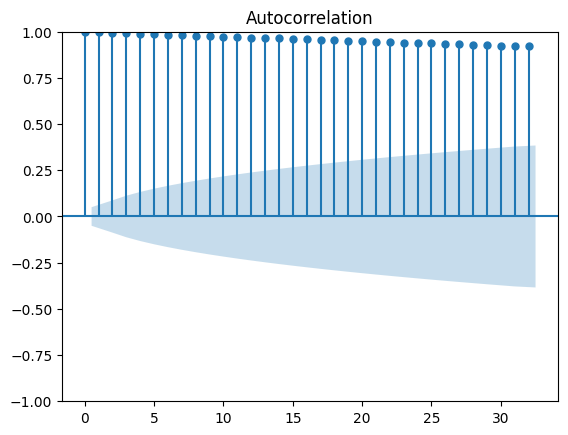

In [107]:
series = open_prices
plot_acf(series)
plt.show()

In [108]:
# Create and train the autoregressive model
lag_order = 135 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train, lags=lag_order)
ar_results = ar_model.fit()

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [109]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
#print(y_pred)
 
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_scoree =r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score: {r2_scoree:.2f}')

Mean Absolute Error: 14.91
Root Mean Squared Error: 17.91
r2_score: 0.49


C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


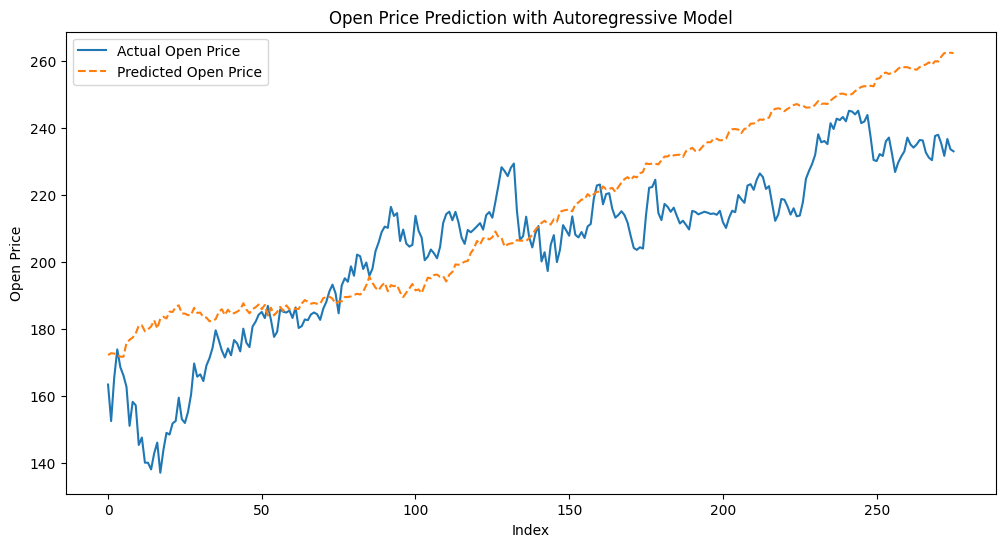

In [110]:
# Ensure the index for test_data is aligned correctly with y_pred
test_data.reset_index(drop=True, inplace=True)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Open Price')
plt.plot(test_data.index, y_pred, label='Predicted Open Price', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Open Price')
plt.legend()
plt.title('Open Price Prediction with Autoregressive Model')
plt.show()

## Moving Average 

In [111]:
# Load the dataset
data = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'], index_col='Date')

# Focus on the 'Open' prices
open_prices = data['Open']

# Split the data into training and testing sets
train_size = int(len(open_prices) * 0.8)
train, test = open_prices[:train_size], open_prices[train_size:]

In [112]:
from scipy.ndimage import uniform_filter1d
 
# Calculate 3-day Simple Moving Average (SMA)
data['SMA3'] = open_prices.rolling(3).mean()

In [113]:
data.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
SMA3      2
dtype: int64

In [114]:
data.dropna(inplace=True)

<Axes: xlabel='Date'>

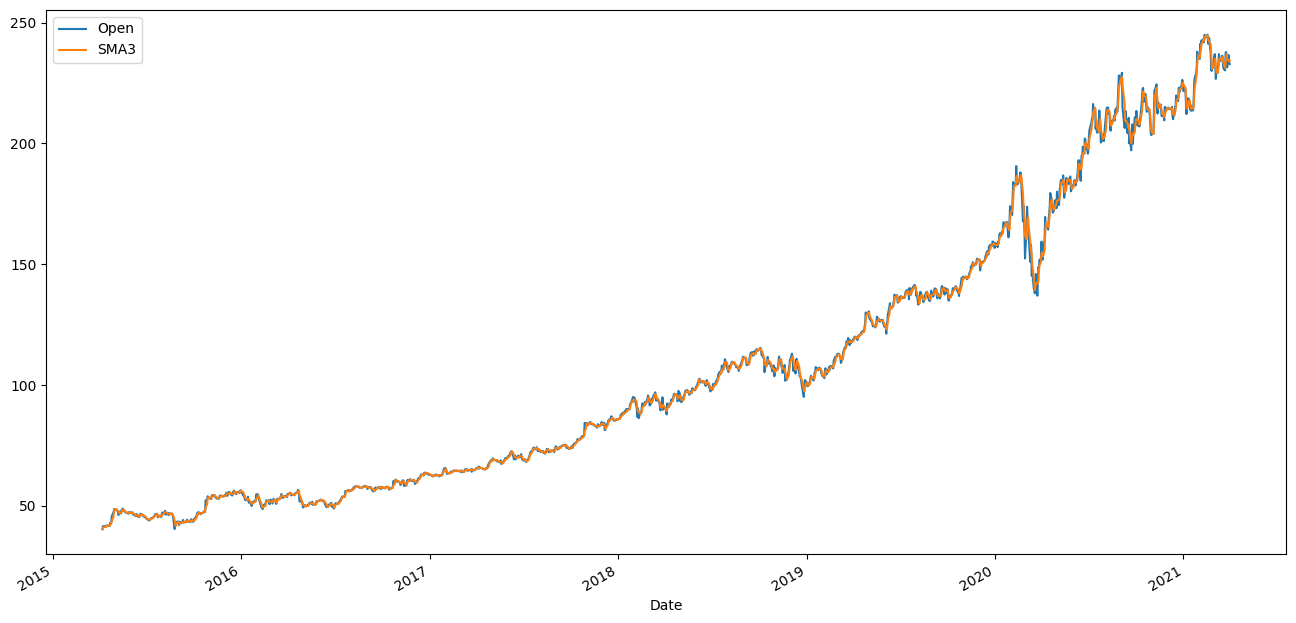

In [115]:
data[['Open', 'SMA3']].plot(label='RELIANCE', 
                                  figsize=(16, 8))

## ARIMA

In [116]:
# Load the dataset
data = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'], index_col='Date')

# Focus on the 'Open' prices
open_prices = data['Open']

# Split the data into training and testing sets
train_size = int(len(open_prices) * 0.8)
train, test = open_prices[:train_size], open_prices[train_size:]

In [117]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

test_stationarity(open_prices)


ADF Statistic: 0.8239150328103293
p-value: 0.9920125565435898
Critical Value (1%): -3.4346938104971554
Critical Value (5%): -2.863458518103151
Critical Value (10%): -2.567791394384679


In [118]:
# Differencing to make the series stationary
differenced_series = open_prices.diff().dropna()

In [119]:
# Re-test for stationarity
test_stationarity(differenced_series)


ADF Statistic: -9.91356513937029
p-value: 3.1226582463678135e-17
Critical Value (1%): -3.43476120520139
Critical Value (5%): -2.863488262178673
Critical Value (10%): -2.567807233388883


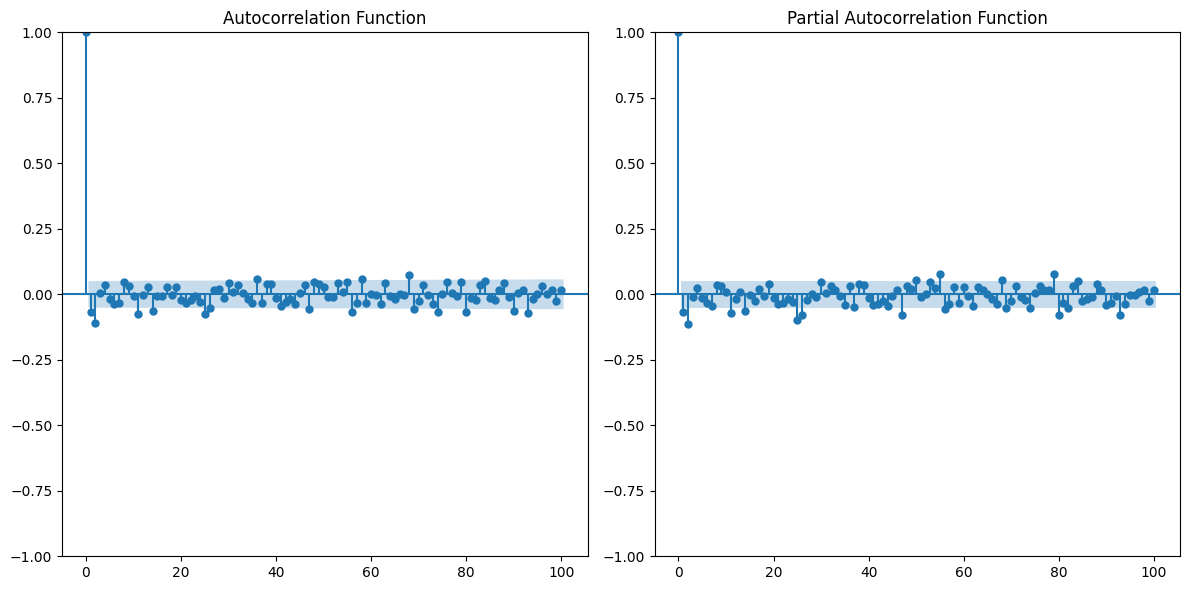

In [120]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(differenced_series, lags=100, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(differenced_series, lags=100, ax=plt.gca(), method='ols')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [121]:
# Split the data into training and testing sets
train_size = int(len(differenced_series) * 0.8)
train, test = differenced_series[:train_size], differenced_series[train_size:]

In [122]:

model = ARIMA(train, order=(100, 2, 13))
model_fit = model.fit()

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zer

In [123]:
train

Date
2015-04-01 16:00:00     40.60
2015-04-02 16:00:00     40.66
2015-04-06 16:00:00     40.34
2015-04-07 16:00:00     41.61
2015-04-08 16:00:00     41.48
                        ...  
2020-01-10 16:00:00    162.82
2020-01-13 16:00:00    161.76
2020-01-14 16:00:00    163.39
2020-01-15 16:00:00    162.62
2020-01-16 16:00:00    164.35
Name: Open, Length: 1208, dtype: float64

In [124]:
# for i in range(1, 135):
#     correlation = data['Open'].corr(data[f'Lag_{i}'])
#     print(f"AutoCorrelation {i}: {correlation:.4f}")

lag_order = 135 # Adjust this based on the ACF plot
ar_model = AutoReg(train, lags=lag_order)
ar_results = ar_model.fit()

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [125]:
# forecast = model_fit.predect(steps=len(test))
forecast = ar_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
# start=len(train), end=len(train) + len(test) - 1, dynamic=False

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [126]:
# Evaluate the model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')

MAE: 9.721187992137901
RMSE: 12.569131929413519
R^2 Score: 0.7563139583758323


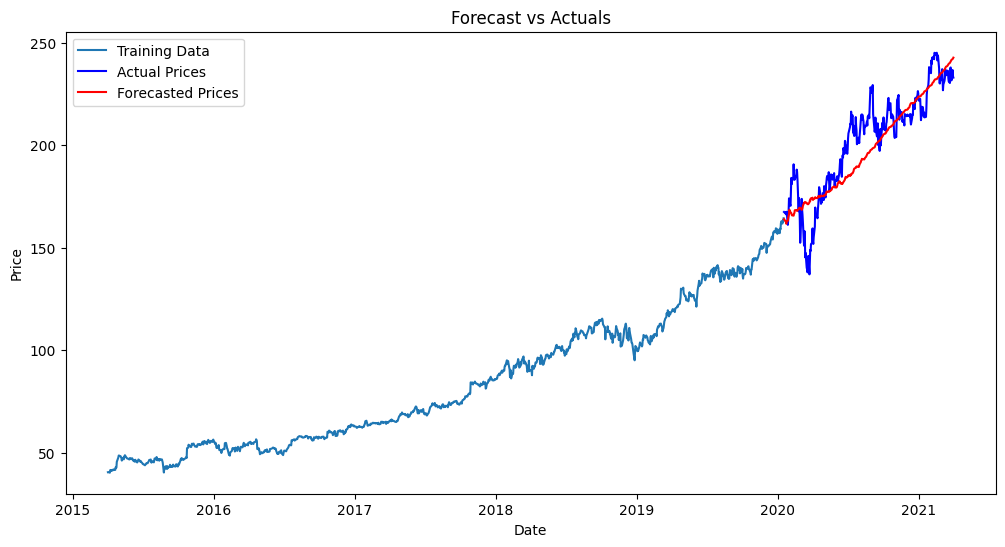

In [82]:
# Plot the forecast vs actuals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## SARIMAX

In [127]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [134]:
# Load the dataset
data = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'], index_col='Date')

# Focus on the 'Open' prices
open_prices = data['Open']

In [135]:
# Split the data into training and testing sets
train_size = int(len(open_prices) * 0.8)
train, test = open_prices[:train_size], open_prices[train_size:]

In [136]:
# Fit the SARIMA model 
model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12)) 
results = model.fit() 
model 

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [137]:
lag_order = 135 # Adjust this based on the ACF plot
ar_model = AutoReg(train, lags=lag_order)
ar_results = ar_model.fit()

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [138]:
forecast = ar_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)


C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


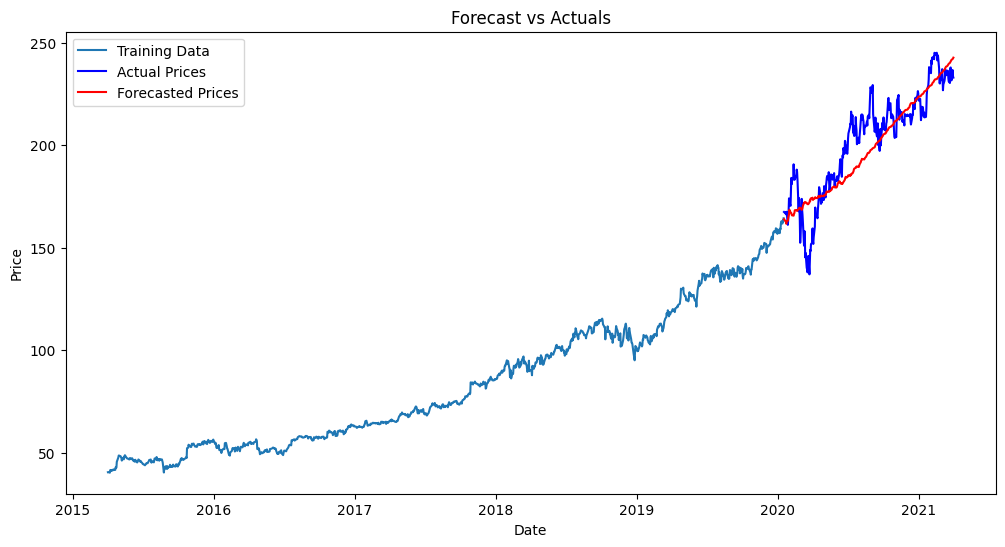

In [133]:
# Plot the forecast vs actuals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()